# Determining the Best Predictor of a NBA Player's Efficiency Rating 

Madison Chester

Project 2

March 1st, 2022

## Introduction

The dataset that will be explored in this analysis is NBA Player Stats for the 2021-2022 season and can be found at https://www.kaggle.com/vivovinco/nba-player-stats. For reference, this dataset only contains players that logged minutes in a game this season, and hence, any players that did not play due to injury or other reasons are not included.This dataset contains any simple statistics that would be important indicators of the strength of a player's game. Additionally, this data set includes some advanced statistics. Before familiarizing you with the meanings and background calculations of these advanced statistics though, let's read in the data and some necessary libraries we will need for data processing and visualization, as well as look at a summary of the data to introduce you to the variables.

In [1]:
# import necessary libraries
from scipy import stats
import requests
import csv
from bs4 import BeautifulSoup 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nba = pd.read_csv('NBAPlayerStats.csv', sep = ";")
print(nba.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      590 non-null    int64  
 1   Player  590 non-null    object 
 2   Pos     590 non-null    object 
 3   Age     590 non-null    int64  
 4   Tm      590 non-null    object 
 5   G       590 non-null    int64  
 6   GS      590 non-null    int64  
 7   MP      590 non-null    float64
 8   FG      590 non-null    float64
 9   FGA     590 non-null    float64
 10  FG%     590 non-null    float64
 11  3P      590 non-null    float64
 12  3PA     590 non-null    float64
 13  3P%     590 non-null    float64
 14  2P      590 non-null    float64
 15  2PA     590 non-null    float64
 16  2P%     590 non-null    float64
 17  eFG%    590 non-null    float64
 18  FT      590 non-null    float64
 19  FTA     590 non-null    float64
 20  FT%     590 non-null    float64
 21  ORB     590 non-null    float64
 22  DR

### Simple Statistics 

Looking at the summary, the simple descriptive statistics include the player's name, position, age, and team. Some others include games played (G), games started (GS), average minutes played per game (MP), average field goals, three pointers, two pointers, and free throws made per game (FG, 3P, 2P, FT), attempts per game (FGA, 3PA, 2PA, FTA), and overall percentage (FG%, 3P%, 2P%, FT%), as well as average offensive (ORB), defensive (DRB), and total rebounds per game (TRB), average assists per game (AST), average steals per game (STL), average blocks per game (BLK), average turnovers per game (TOV), average personal fouls per game (PF), and lastly, average points per game (PTS). 

To clairfy some defintions in terms of basketball:
- An assist is loosely defined as being attributed to a player who passes the ball to a teammate in a way that leads to a score by field goal (some judgement is included in this statistic).

- A steal occurs only when a defensive player forces a turnover from an offensive player and gains possession of the ball.

- Blocks refer to when a defensive player deflects a scoring attempt of an offensive player.

- A turnover is defined as when a player loses possession of the ball to the opposing team.

- A foul is illegal personal contact or unsportsmanlike conduct on the court or sidelines of a game.

Some additional information that may be helpful to know includes:
- There are 30 teams represented in the NBA.

- The regular season (excluding playoffs) contains 82 games.

- 4, 12-minute quarters are played in an NBA game.

- Positions include center, power forward, point guard, small forward, and shooting guard.

- For a player to be considered good, they normally average at least 20 points per game.

- Simply put, a good field goal percentage is considered to be including and exceeding 45%.

- A good 3-point percentage is considered to be anything including and exceeding 40%.

- Most free throw percentages considered good are above 75%.

- A player is allowed 5 personal fouls before they have "fouled-out", and then are disqualified from participation for the remainder of the game.

### Advanced Statistics

Now, there are only two advanced statistics involved in this dataset, and those include rank (Rk), which is based on the magnitude of a Player's Efficiency Rating, and effective field goal percentage (eFG%). Effective field goal percentage is a statistic that takes into account that three-pointers are worth more than regular field goals and is calculated as follows: 

                                            (FG + 0.5 * 3P) / FGA * 100

For example, say Player A is 4/10 from the field, going 2/2 from three. Player B is 5/10 from the field, 0/0 from three. Both players have 10 points in the game, but player A’s field goal percentage is 40%, while player B’s is 50%. At an initial glance, player B was more efficient this game. However, using eFG%, taking into account player A’s two threes, both players sit at a 50% eFG%.

On another hand, say another player misses many shots, but also shoots many free throws that also count towards his point total. To take this into account, we need a more advanced shooting statistic like true shooting percentage, which takes into account all the ways a player can score and is calculated as follows:

                                          PTS / (2(FGA + (0.44 * FTA))) * 100
                                          
This statistic tries to better capture how efficiently a player can score. This will be added to our dataset when cleaning and and processing the data. As for rank, this is the main statistic this report will be concerned with.

## Defining the Problem 

For this report, I will be investigating which individual player statistics are the best indicators of a player's rank or PER, player efficiency rating. 

This statistic is what all players are ranked on in the league. A league average PER is 15.00, and it takes into account accomplishments and negative results of a player's game. The formula adds positive statistics and subtracts negative ones through a statistical point value system, and the rating for each player is then adjusted to a per-minute basis. It is also adjusted for the team's pace. In the end, one number sums up the players' statistical accomplishments for that season. 

Before continuing, however, I feel it is important to note the limitations to this statistic. It has been said that PER mostly only takes into account a player's offensive performance and does not accurately take into account a player's defensive acumen. Some people also argue that this statistic rewards inefficient shooting. Nevertheless, this is the best statistic we have to date to objectively rank all players. 

## Cleaning and Processing the Data 

Before doing any statistical analysis, however, some modifications of the data need to be made. 

First off, some renaming of the columns will be done to more easily identify what statistic each column represents.

In [2]:
nba.rename(columns = {'FG':'fg.per.game'}, inplace = True)
nba.rename(columns = {'FGA':'fga.per.game'}, inplace = True)
nba.rename(columns = {'FG%':'fg.percentage'}, inplace = True)
nba.rename(columns = {'FT':'ft.per.game'}, inplace = True)
nba.rename(columns = {'FTA':'fta.per.game'}, inplace = True)
nba.rename(columns = {'FT%':'ft.percentage'}, inplace = True)

nba.rename(columns = {'3P':'fg3.per.game'}, inplace = True)
nba.rename(columns = {'3PA':'fga3.per.game'}, inplace = True)
nba.rename(columns = {'3P%':'fg3.percentage'}, inplace = True)
nba.rename(columns = {'2P':'fg2.per.game'}, inplace = True)
nba.rename(columns = {'2PA':'fga2.per.game'}, inplace = True)
nba.rename(columns = {'2P%':'fg2.percentage'}, inplace = True)

nba.rename(columns = {'eFG%':'effective.fg.percentage'}, inplace = True)

Now, I will create the advanced statistic of true shooting percentage that was discussed previously. 

In [3]:
nba['true.percentage'] = nba['PTS'] / (2 * (nba['fga.per.game'] + (0.44 * nba['fta.per.game']))) * 100

Lastly, I will reorder the columns to place true shooting percentage next to effective shooting percentage. 

In [4]:
nba = nba[['Rk','Player','Pos','Age','Tm','G','GS','MP','fg.per.game','fga.per.game','fg.percentage','fg3.per.game',
           'fga3.per.game','fg3.percentage','fg2.per.game','fga2.per.game','fg2.percentage','ft.per.game','fta.per.game',
           'ft.percentage','effective.fg.percentage','true.percentage','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']]

Fortunately, this data was quite clean already before I decided to work with it, so not too much processing is required.

## Exploratory Analysis 

Initially, to determine the strength and direction of the relationship between the dataset's variables and a player's rank, we can compute the Pearson correlational coefficient for quantitative continuous variables for all pairs of variables in the dataset by creating a correlation matrix. We can then display this matrix aesthetically using packages seaborn and matplotlib.

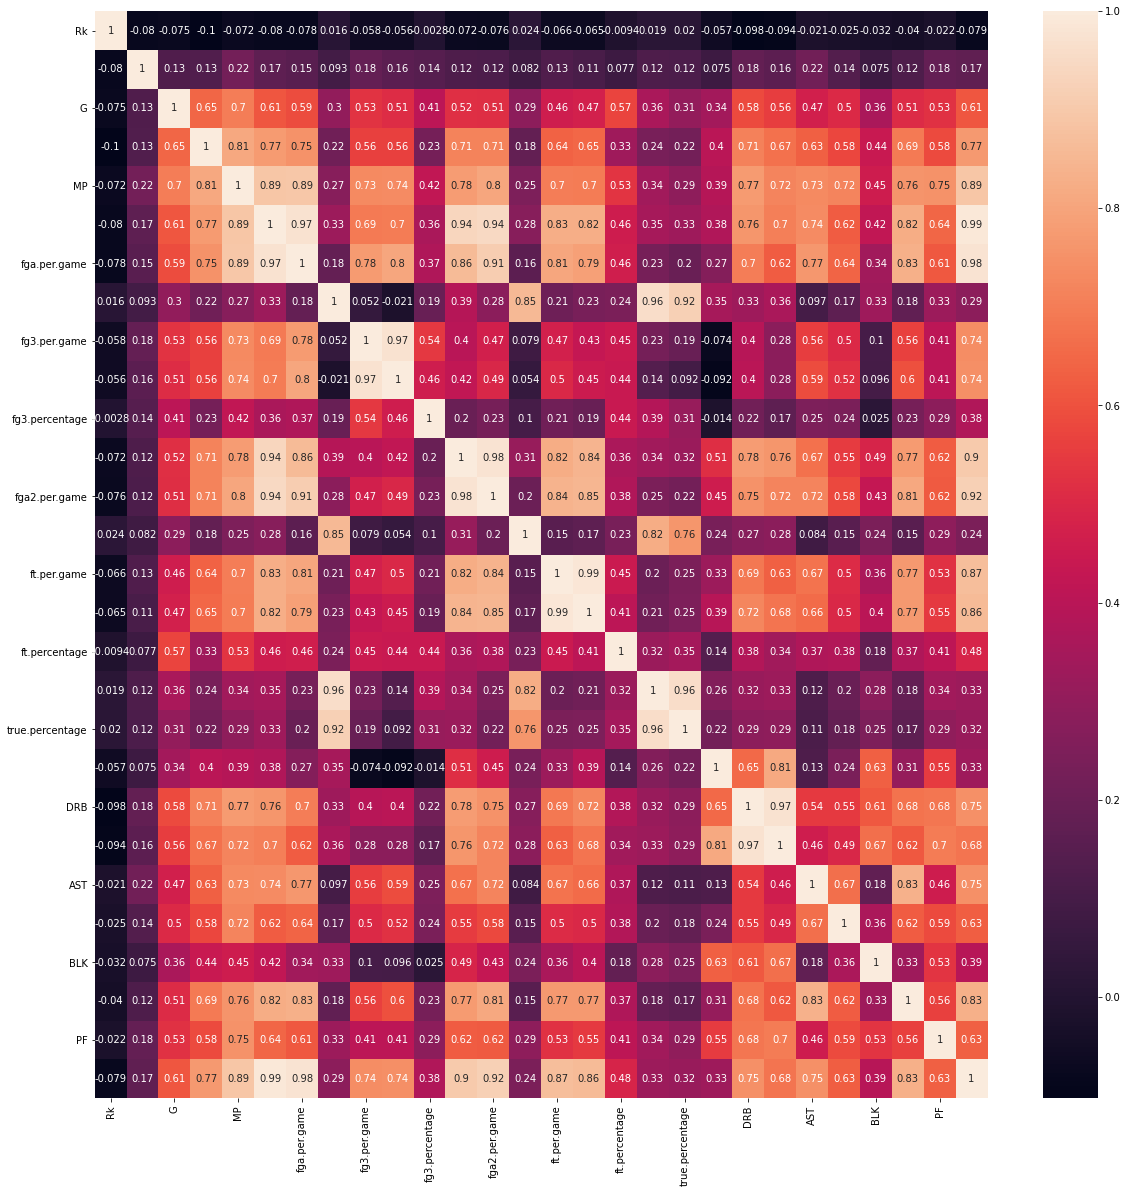

In [5]:
corrMatrix = nba.corr()
fig = plt.figure()
rep = fig.add_subplot(1,1,1)
rep = sns.heatmap(corrMatrix, annot = True)
fig.set_size_inches(20, 20)
plt.show()

As mentioned above, correlation coefficients can tell us the strength and direction of a relationship between two variables. A correlation coefficient has a range of -1 to 1. The sign of the value indicates the direction of the relationship (linearly negative or linearly positive), and the magnitude of the value indicates the strength of the relationship. This means that a correlation of or near 0 indicates independence between two variables, and a correlation of -1 or 1 indicates a perfectly linear relationship. 

In reference to the plot generated above, each cell's magnitude and direction of correlation is represented by shade of color. Darker shades in this plot indicate a correlation coefficient closer to 0, and brighter shades correspond to a correlation coefficient closer to 1.

After analyzing this plot, we can see that no variable has a strong correlation with rank, or a player's efficiency rating. However, the plot does reveal strong relationships between some simple statistics. 

With all of this being said, however, a correlation coefficient could be biased due to a significant outlier in a dataset. Not to mention, a correlation coefficient may miss a non-linear link between two variables. For this reason, it is important to visualize the relationship between two variables in addition to computing their correlation.

To start, since player efficiency rating is said to favor inefficient shooting and take more into account a player's offensive game rather than their defensive, it may be revealing to visualize the relationship betweeen a player's shooting statistics and their rank. 

The shooting statistics to be plotted against rank include: 
- field goals per game
- field goal attempts per game
- field goal percentage
- 3 point field goals per game
- 3 point field goal attempts per game
- 3 point field goal percentage
- 2 point field goals per game
- 2 point field goal attempts per game
- 2 point field goal percentage
- free throws per game
- free throw attempts per game
- free throw percentage 

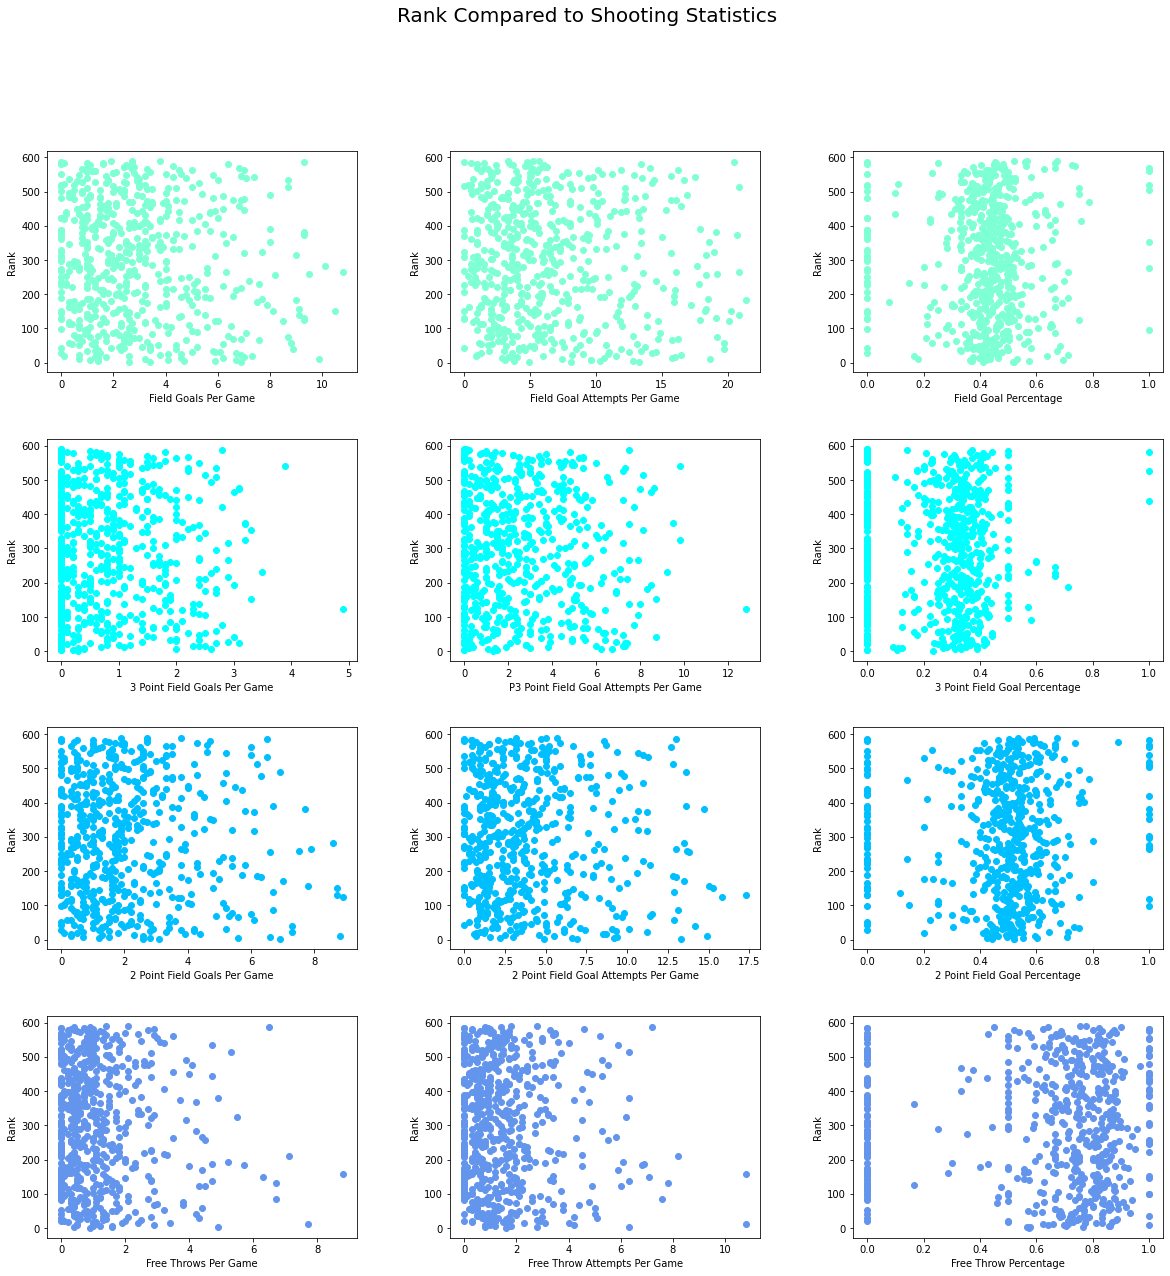

In [6]:
fig = plt.figure()

ax1 = fig.add_subplot(4,3,1)
ax2 = fig.add_subplot(4,3,2)
ax3 = fig.add_subplot(4,3,3)
ax4 = fig.add_subplot(4,3,4)
ax5 = fig.add_subplot(4,3,5)
ax6 = fig.add_subplot(4,3,6)
ax7 = fig.add_subplot(4,3,7)
ax8 = fig.add_subplot(4,3,8)
ax9 = fig.add_subplot(4,3,9)
ax10 = fig.add_subplot(4,3,10)
ax11 = fig.add_subplot(4,3,11)
ax12 = fig.add_subplot(4,3,12)

ax1.scatter(nba['fg.per.game'], nba.Rk, c = "aquamarine")
ax1.set_xlabel("Field Goals Per Game")
ax1.set_ylabel("Rank")
ax2.scatter(nba['fga.per.game'], nba.Rk, c = "aquamarine")
ax2.set_xlabel("Field Goal Attempts Per Game")
ax2.set_ylabel("Rank")
ax3.scatter(nba['fg.percentage'], nba.Rk, c = "aquamarine")
ax3.set_xlabel("Field Goal Percentage")
ax3.set_ylabel("Rank")
ax4.scatter(nba['fg3.per.game'], nba.Rk, c = "cyan")
ax4.set_xlabel("3 Point Field Goals Per Game")
ax4.set_ylabel("Rank")
ax5.scatter(nba['fga3.per.game'], nba.Rk, c = "cyan")
ax5.set_xlabel("P3 Point Field Goal Attempts Per Game")
ax5.set_ylabel("Rank")
ax6.scatter(nba['fg3.percentage'], nba.Rk, c = "cyan")
ax6.set_xlabel("3 Point Field Goal Percentage")
ax6.set_ylabel("Rank")
ax7.scatter(nba['fg2.per.game'], nba.Rk, c = "deepskyblue")
ax7.set_xlabel("2 Point Field Goals Per Game")
ax7.set_ylabel("Rank")
ax8.scatter(nba['fga2.per.game'], nba.Rk, c = "deepskyblue")
ax8.set_xlabel("2 Point Field Goal Attempts Per Game")
ax8.set_ylabel("Rank")
ax9.scatter(nba['fg2.percentage'], nba.Rk, c = "deepskyblue")
ax9.set_xlabel("2 Point Field Goal Percentage")
ax9.set_ylabel("Rank")
ax10.scatter(nba['ft.per.game'], nba.Rk, c = "cornflowerblue")
ax10.set_xlabel("Free Throws Per Game")
ax10.set_ylabel("Rank")
ax11.scatter(nba['fta.per.game'], nba.Rk, c = "cornflowerblue")
ax11.set_xlabel("Free Throw Attempts Per Game")
ax11.set_ylabel("Rank")
ax12.scatter(nba['ft.percentage'], nba.Rk, c = "cornflowerblue")
ax12.set_xlabel("Free Throw Percentage")
ax12.set_ylabel("Rank")

fig.set_size_inches(20,20)
fig.suptitle("Rank Compared to Shooting Statistics", fontsize = 20)
plt.subplots_adjust(wspace = .30, hspace = .30)

Secondly, it may be interesting to determine if a player's offensive statistics can be a reliable indicator of their defensive statistics. We can investigate this by determining what relationships exist between points per game and personal fouls per game, defensive rebounds per game, steals per game, and blocks per game. Although it may be intuitive why defensive rebounds, steals, and blocks are used to represent defensive statistics, I would argue personal fouls are also a good indicator of a player's defensive strength. This is due to the fact that normally, player's who either put the most effort in on defense or play the most aggressive defense are the ones that end up with the most personal fouls per game. 

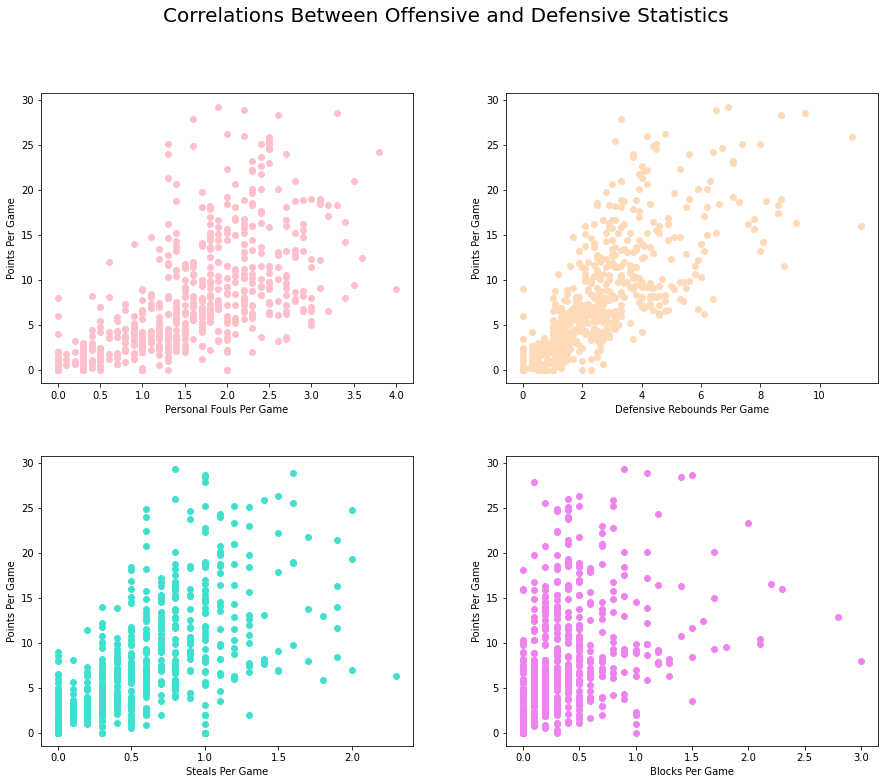

In [7]:
fig = plt.figure()

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(nba.PF, nba.PTS, c = "pink")
ax1.set_xlabel("Personal Fouls Per Game")
ax1.set_ylabel("Points Per Game")
ax2.scatter(nba.DRB, nba.PTS, color = "peachpuff")
ax2.set_xlabel("Defensive Rebounds Per Game")
ax2.set_ylabel("Points Per Game")
ax3.scatter(nba.STL, nba.PTS, color = "turquoise")
ax3.set_xlabel("Steals Per Game")
ax3.set_ylabel("Points Per Game")
ax4.scatter(nba.BLK, nba.PTS, color = "violet")
ax4.set_xlabel("Blocks Per Game")
ax4.set_ylabel("Points Per Game")

fig.set_size_inches(15, 12)
fig.suptitle("Correlations Between Offensive and Defensive Statistics", fontsize = 20)
plt.subplots_adjust(wspace = .25, hspace = .25)

Now, after visualizing the relationship between these offensive and defensive statistics, we can individually calculate their correlation coefficients. It can be seen below that personal fouls per game, defensive rebounds per game, and steals per game have a moderately strong positive correlation with points per game. There still exists a correlation between blocks per game and points per game, but it is not as strong. 

In [8]:
corr1 = np.corrcoef(nba.PF, nba.PTS)
print(corr1)
corr2 = np.corrcoef(nba.DRB, nba.PTS)
print(corr2)
corr3 = np.corrcoef(nba.STL, nba.PTS)
print(corr3)
corr4 = np.corrcoef(nba.BLK, nba.PTS)
print(corr4)

[[1.         0.63067974]
 [0.63067974 1.        ]]
[[1.         0.74925183]
 [0.74925183 1.        ]]
[[1.         0.62684306]
 [0.62684306 1.        ]]
[[1.         0.39286407]
 [0.39286407 1.        ]]


Moreover, it may be produtive to analyze the relationship between offensive rebounds per game and assists per game. This may not seem like an intuitive pairing; however, both offensive rebounds and an assists can greatly increase the offensive productivity of a team, yet neither happen quite frequently. An offensive rebound requires proactivity on the hands of the player to establish position in the paint, and an assist requires full awareness of all players on both offense and defense, and more importantly, excellent communication between the passer and finisher. 

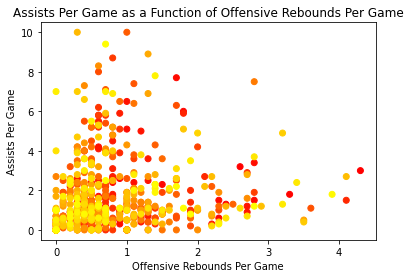

[[1.         0.12511834]
 [0.12511834 1.        ]]


In [9]:
plt.scatter(nba['ORB'], nba['AST'], c = nba.Rk, cmap = "autumn")
plt.xlabel("Offensive Rebounds Per Game")
plt.ylabel("Assists Per Game")
plt.title("Assists Per Game as a Function of Offensive Rebounds Per Game")
plt.show()

corr5 = np.corrcoef(nba['ORB'], nba['AST'])
print(corr5)

It can be seen that the correlation coefficient between offensive rebounds per game and assists is relatively small and positive. 

Lastly, it could be revealing to analyze steals and turnovers against one another due to the fact that these two statistics are inverses of each other. A steal occurs when a defensive player is able to force a turnover from the offense, and a turnvoer occurs when the defense recovers the ball due to the offensive player's mistake. Hence, pinning these variables against one another may show that both variables are correlated due to some level of risk a player is willing to take, etc. Risk is involved due to the fact that normally getting a steal requires a defensive player to momentarily lose their defensive position between their man and the basket, which could leave an opening for the offense, and in relation to turnovers, a lot of times these are logged because a player is willing to try and make a narrow pass between two defenders or throw a high-risk, high-reward pass.

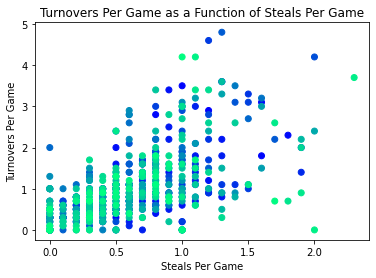

[[1.         0.62145602]
 [0.62145602 1.        ]]


In [10]:
plt.scatter(nba['STL'], nba['TOV'], c = nba.Rk, cmap = "winter")
plt.xlabel("Steals Per Game")
plt.ylabel("Turnovers Per Game")
plt.title("Turnovers Per Game as a Function of Steals Per Game")
plt.show()

corr6 = np.corrcoef(nba['STL'], nba['TOV'])
print(corr6)

It can be seen that the correlation coefficient between steals per game and turnovers per game is moderately strong and positive. 

On another hand, a correlation test can be used to test whether the correlation between two variables in a population is significantly different from 0 or not. The null and alternative hypotheses for the correlation test are 

H0: $\rho$ = 0 (meaning that there is no linear relationship between the two variables)

H1: $\rho$ $\neq$ 0 (meaning that there is a linear relationship between the two variables)

Through this correlation test, we are able to test whether we have significant evidence to conclude that the correlation coefficient does not equal 0, meaning a relationship exists in the population. Significant evidence is indicated by a P-value less than the standard $\alpha$ level of 0.05. 

Unfortunately, there is no direct way to compute a matrix that contains the correlation coefficient and p-value of a correlation test between many variables, so it must be created manually. Below, I calculate the p-value of the correlation tests between the shooting statistics (true shooting percentage not included because it has missing values) and rank using the scipy.stats package and the pearsonr function (I will also do this separately for all other attributes in the dataset). I then combine the tuples returned by pearsonr for each variable comparison consisting of the correlation coefficient and p-value to form a dataframe. I then reprint the dataframe to only display relationships where the p-value is of significance. 

In [11]:
p_rank_fg = stats.pearsonr(nba['Rk'], nba['fg.per.game'])
p_rank_fga = stats.pearsonr(nba['Rk'], nba['fga.per.game'])
p_rank_fgp = stats.pearsonr(nba['Rk'], nba['fg.percentage'])
p_rank_fg3 = stats.pearsonr(nba['Rk'], nba['fg3.per.game'])
p_rank_fga3 = stats.pearsonr(nba['Rk'], nba['fga3.per.game'])
p_rank_fg3p = stats.pearsonr(nba['Rk'], nba['fg3.percentage'])
p_rank_fg2 = stats.pearsonr(nba['Rk'], nba['fg2.per.game'])
p_rank_fga2 = stats.pearsonr(nba['Rk'], nba['fga2.per.game'])
p_rank_fg2p = stats.pearsonr(nba['Rk'], nba['fg2.percentage'])
p_rank_ft = stats.pearsonr(nba['Rk'], nba['ft.per.game'])
p_rank_fta = stats.pearsonr(nba['Rk'], nba['fta.per.game'])
p_rank_ftp = stats.pearsonr(nba['Rk'], nba['ft.percentage'])
p_rank_efg = stats.pearsonr(nba['Rk'], nba['effective.fg.percentage'])

p_rank_games = stats.pearsonr(nba['Rk'], nba['G'])
p_rank_started = stats.pearsonr(nba['Rk'], nba['GS'])
p_rank_minutes = stats.pearsonr(nba['Rk'], nba['MP'])
p_rank_orb = stats.pearsonr(nba['Rk'], nba['ORB'])
p_rank_drb = stats.pearsonr(nba['Rk'], nba['DRB'])
p_rank_trb = stats.pearsonr(nba['Rk'], nba['TRB'])
p_rank_ast = stats.pearsonr(nba['Rk'], nba['AST'])
p_rank_stl = stats.pearsonr(nba['Rk'], nba['STL'])
p_rank_blk = stats.pearsonr(nba['Rk'], nba['BLK'])
p_rank_tov = stats.pearsonr(nba['Rk'], nba['TOV'])
p_rank_pf = stats.pearsonr(nba['Rk'], nba['PF'])
p_rank_pts = stats.pearsonr(nba['Rk'], nba['PTS'])

shooting = [p_rank_fg, p_rank_fga, p_rank_fgp, p_rank_fg3, p_rank_fga3, p_rank_fg3p, p_rank_fg2, p_rank_fga2, p_rank_fg2p, 
            p_rank_ft, p_rank_fta, p_rank_ftp, p_rank_efg]
        
others = [p_rank_games, p_rank_started, p_rank_minutes, p_rank_orb, p_rank_drb, p_rank_trb, p_rank_ast, p_rank_stl, p_rank_blk, 
          p_rank_tov, p_rank_pf, p_rank_pts]

shoot_stats = pd.DataFrame(shooting, columns = ['Correlation Coefficient', 'P-value'])
print(shoot_stats)
print(shoot_stats[shoot_stats['P-value'] < 0.05]) 

other_stats = pd.DataFrame(others, columns = ['Correlation Coefficient', 'P-value'])
print(other_stats)
print(other_stats[other_stats['P-value'] < 0.05]) 

    Correlation Coefficient   P-value
0                 -0.079692  0.053030
1                 -0.078350  0.057172
2                  0.016425  0.690528
3                 -0.057674  0.161782
4                 -0.055894  0.175148
5                 -0.002782  0.946248
6                 -0.072000  0.080560
7                 -0.076492  0.063344
8                  0.023917  0.562060
9                 -0.066275  0.107796
10                -0.065295  0.113116
11                -0.009360  0.820524
12                 0.019060  0.644071
Empty DataFrame
Columns: [Correlation Coefficient, P-value]
Index: []
    Correlation Coefficient   P-value
0                 -0.075199  0.067957
1                 -0.102676  0.012585
2                 -0.071966  0.080706
3                 -0.056654  0.169348
4                 -0.098460  0.016742
5                 -0.093504  0.023125
6                 -0.020786  0.614354
7                 -0.025252  0.540433
8                 -0.032153  0.435669
9                 

Based on this, we are able to see that player efficiency rating does not have a statistically significant relationship with any shooting statistics. However, rank does seem to have a statistically significant relationship with games started, defensive rebounds per game, and total rebounds per game. 

I will now perform the same operation on the correlations between offensive and defensive statistics, offensive rebounds and assists, and steals and turnovers. 

P-values of Correlations Between Offensive and Defensive Statistics:

In [12]:
p_pts_pf = stats.pearsonr(nba['PTS'], nba['PF'])
print(p_pts_pf)
p_pts_drb = stats.pearsonr(nba['PTS'], nba['DRB'])
print(p_pts_drb)
p_pts_stl = stats.pearsonr(nba['PTS'], nba['STL'])
print(p_pts_stl)
p_pts_blk = stats.pearsonr(nba['PTS'], nba['BLK'])
print(p_pts_blk)

(0.6306797434169644, 9.312387616196101e-67)
(0.7492518317988042, 2.608296594305955e-107)
(0.6268430586091478, 9.7838526060895e-66)
(0.3928640693775858, 3.2667341352757183e-23)


P-value of Correlation Test Between Offensive Rebounds Per Game and Assists Per Game:

In [13]:
p_orb_ast = stats.pearsonr(nba['ORB'], nba['AST'])
print(p_orb_ast)

(0.1251183419286029, 0.0023295812365181287)


P-value of Correlation Test Between Steals Per Game and Turnovers Per Game:

In [14]:
p_stl_tov = stats.pearsonr(nba['STL'], nba['TOV'])
print(p_stl_tov)

(0.6214560243853349, 2.5166291747055225e-64)


## Interpretation of Results 

In conclusion, it can be seen that no single statistic is capable of accurately predicting rank by itself, and that a Player's Efficieny Rating is much too complicated of a statistic to produce meaningful correlations between any simple statistics and even some advanced statistics. This is not the conclusion I was hoping to reach or even expecting to reach, but it makes sense that a game as complicated as basketball and a topic so subjective as player performance and talent level cannot be boiled down to a single descriptive statistic, although moderately strong correlations were present with games started, defensive rebounds per game, and total rebounds per game.

As for the relationship between offensive and defensive statistics, it can be concluded that offensive statistics (points per game) and defensive statistics (personal fouls per game, defensive rebounds per game, steals per game, and blocks per game) have some relationship as all four relationship comparisons produced a significant p-value. Lastly, in relation to offensive rebounds per game and assists per game, it can be seen that these variables have some relationship as well with a p-value of .002330, and steals per game and turnovers per game also have a relationship as communicated by their very strong p-value of 2.5166e-64.

### Sources 

2021-2022 NBA Player Stats: <br> https://www.kaggle.com/vivovinco/nba-player-stats <br>

Player Efficiency Rating - Skeptical Sports Analysis: <br> https://skepticalsports.com/tag/per/#:~:text=Unsurprisingly%2C%20%E2%80%9Cminutes%20per%20game%E2%80%9D,rate%20statistic%2C%20including%20true%20shooting <br>

Basketball Reference Glossary: <br> https://www.basketball-reference.com/about/glossary.html#header) <br>

Calculating PER: <br> https://www.basketball-reference.com/about/per.html) <br>